# Filter Example

This example demonstrates the connection between MKS and signal
processing for a 1D filter. It shows that the filter is in fact the
same as the influence coefficients and, thus, applying the `predict`
method provided by the `MKSLocalizationnModel` is in essence just applying a filter.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt


Here we construct a filter, $F$, such that

$$F\left(x\right) = e^{-|x|} \cos{\left(2\pi x\right)} $$

We want to show that, if $F$ is used to generate sample calibration
data for the MKS, then the calculated influence coefficients are in
fact just $F$.

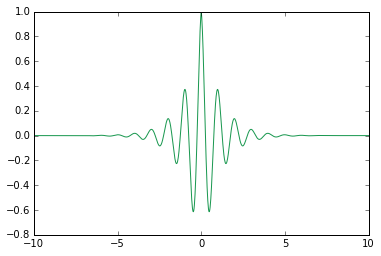

In [2]:
x0 = -10.
x1 = 10.
x = np.linspace(x0, x1, 1000)
def F(x):
    return np.exp(-abs(x)) * np.cos(2 * np.pi * x)
p = plt.plot(x, F(x), color='#1a9850')


Next we generate the sample data `(X, y)` using
`scipy.ndimage.convolve`. This performs the convolution

$$ p\left[ s \right] = \sum_r F\left[r\right] X\left[r - s\right] $$

for each sample.

In [3]:
import scipy.ndimage


n_space = 101
n_sample = 50
np.random.seed(201)
x = np.linspace(x0, x1, n_space)
X = np.random.random((n_sample, n_space))
y = np.array([scipy.ndimage.convolve(xx, F(x), mode='wrap') for xx in X])


For this problem, a basis is unnecessary, as no discretization is
required in order to reproduce the convolution with the MKS localization. Using
the `ContinuousIndicatorBasis` with `n_states=2` is the equivalent of a
non-discretized convolution in space.

In [4]:
from pymks import MKSLocalizationModel
from pymks import PrimitiveBasis

p_basis = PrimitiveBasis(n_states=2, domain=[0, 1])
model = MKSLocalizationModel(basis=p_basis)


Fit the model using the data generated by $F$.

In [5]:
model.fit(X, y)


To check for internal consistency, we can compare the predicted
output with the original for a few values

In [6]:
y_pred = model.predict(X)
print y[0, :4]
print y_pred[0, :4]


[-0.41059557  0.20004566  0.61200171  0.5878077 ]
[-0.41059556  0.20004566  0.6120017   0.58780769]


With a slight linear manipulation of the coefficients, they agree perfectly with the shape of the filter, $F$. 

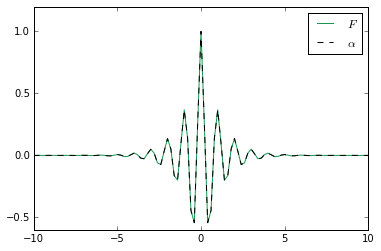

In [7]:
plt.plot(x, F(x), label=r'$F$', color='#1a9850')
plt.plot(x, -model.coef_[:,0] + model.coef_[:, 1], 
         'k--', label=r'$\alpha$')
l = plt.legend()

Some manipulation of the coefficients is required to reproduce the filter. Remember the convolution for the MKS is

$$ p \left[s\right] = \sum_{l=0}^{L-1} \sum_{r=0}^{S - 1} \alpha[l, r] m[l, s - r] $$

However, when the primitive basis is selected, the `MKSLocalizationModel` solves a modified form of this. There are always redundant coefficients since

$$ \sum\limits_{l=0}^{L-1} m[l, s] = 1 $$

Thus, the regression in Fourier space must be done with categorical variables, and the regression takes the following form:


$$ \begin{split}
p [s] & = \sum_{l=0}^{L - 1} \sum_{r=0}^{S - 1} \alpha[l, r] m[l, s -r] \\
P [k] & = \sum_{l=0}^{L - 1} \beta[l, k] M[l, k] \\
&= \beta[0, k] M[0, k] + \beta[1, k] M[1, k]
\end{split}
$$

where

$$\beta[0, k] = \begin{cases}
\langle F(x) \rangle ,& \text{if } k = 0\\
0,              & \text{otherwise}
\end{cases} $$

This removes the redundancies from the regression, and we can reproduce the filter.